In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import h5py
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import math
import matplotlib.patches as patches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):

      h5images = h5py.File(path[0])
      h5masks = h5py.File(path[1])
      self.images = h5images.get(f'{list(h5images.keys())[0]}')
      self.oldmasks = h5masks.get(f'{list(h5masks.keys())[0]}')
      self.labels = np.load(path[2], allow_pickle=True)
      self.bboxs = np.load(path[3], allow_pickle=True)
      j = 0
      m=[]
      for i in range(len(self.labels)):
        m.append(self.oldmasks[j:j+len(self.labels[i])])
        j = j + len(self.labels[i])
      self.masks=np.array(m)
  
    def __getitem__(self, index):

        transed_img,transed_mask,transed_bbox=self.pre_process_batch(self.images[index],self.masks[index],self.bboxs[index])
        label=self.labels[index]
  
        assert transed_img.shape == (3, 800, 1088)
        assert transed_bbox.shape[0] == transed_mask.shape[0]
        return transed_img, label, transed_mask, transed_bbox

    def __len__(self):
        return len(self.images)

    def pre_process_batch(self, img, mask, bbox):

        bbox1 =np.zeros(bbox.shape)

        transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        img = torch.tensor(img.astype(float)).unsqueeze(0)        
        img = transform(F.interpolate(img.clone(), size=(800, 1066), mode='bilinear').squeeze(0))
        img = F.pad(img, (11,11), 'constant', 0) 
        mask = torch.tensor(mask.astype(float)).unsqueeze(0)
        mask = F.interpolate(mask, size=(800, 1066), mode='bilinear').squeeze(0)
        mask = F.pad(mask, (11,11), 'constant', 0)
 
        assert img.shape == (3, 800, 1088)

        assert bbox.shape[0] == mask.shape[0]

        bbox1[:, 0] = bbox[:, 0] * 2.665  + 11
        bbox1[:, 1] = bbox[:, 1] * 2.6667
        bbox1[:, 2] = bbox[:, 2] * 2.665 + 11
        bbox1[:, 3] = bbox[:, 3] * 2.6667
        assert img.shape == (3, 800, 1088)
        assert bbox1.shape[0] == mask.shape[0]
        return img, mask, bbox1

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):
        # TODO: collect_fn
        transed_img_list = []
        label_list = []
        transed_mask_list = []
        
        transed_bbox_list = []
        
     
        for transed_img, label, transed_mask, transed_bbox in batch:

          transed_img_list.append(transed_img)
          label_list.append(label)
          transed_mask_list.append(transed_mask)
          transed_bbox_list.append(transed_bbox)
        return torch.stack(transed_img_list, dim=0),label_list,transed_mask_list,transed_bbox_list

    def loader(self):
        # TODO: return a dataloader

        loader = DataLoader(dataset,batch_size=self.batch_size, shuffle=True,collate_fn=self.collect_fn)
        
        return loader

# **DATASET**

In [ ]:
if __name__ == '__main__':

    imgs_path = '/content/hw3_mycocodata_img_comp_zlib.h5'
    masks_path = '/content/hw3_mycocodata_mask_comp_zlib.h5'
    labels_path = '/content/hw3_mycocodata_labels_comp_zlib.npy'
    bboxes_path = '/content/hw3_mycocodata_bboxes_comp_zlib.npy'
    paths = [imgs_path, masks_path, labels_path, bboxes_path]

    dataset = BuildDataset(paths)

   
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
   
    torch.random.manual_seed(1)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
   

    batch_size = 1
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    train_loader = train_build_loader.loader()
    test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = test_build_loader.loader()

    mask_color_list = ["jet", "ocean", "Spectral", "spring", "cool"]
   
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[293.06359863  80.99712372 738.63031006 754.20019531]]


<Figure size 432x288 with 0 Axes>

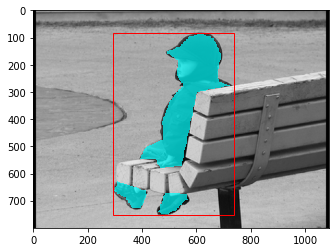

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[451.75354004 346.50759888 744.02075195 768.99755859]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

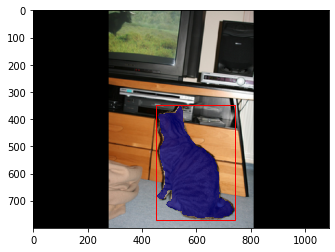

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[191.60372925 369.11080933 442.54675293 513.79144287]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

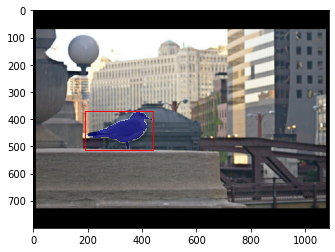

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[309.94638062  42.72000122 753.01922607 449.74484253]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

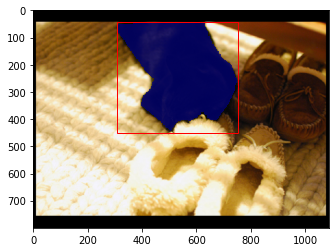

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[ 564.35394287  426.04858398 1077.          786.04803467]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

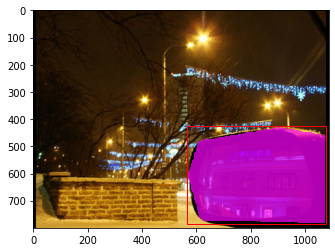

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([2, 800, 1088])
[[ 287.4937439   241.15106201 1022.70062256  719.91546631]
 [ 481.40579224  162.40275574  719.00726318  451.93087769]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

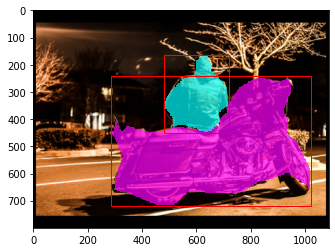

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[242.85499573 385.18490601 572.90454102 801.        ]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

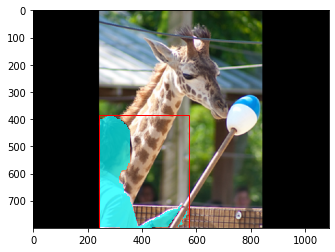

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[114.74312592  96.76081085 728.22607422 801.        ]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

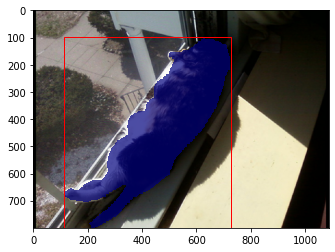

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[246.45274353 468.12194824 638.10778809 788.52197266]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

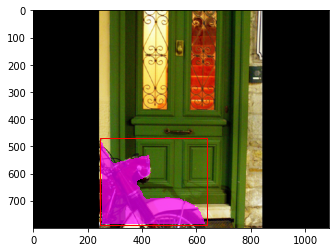

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[261.35324097 554.63757324 364.22225952 778.85467529]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

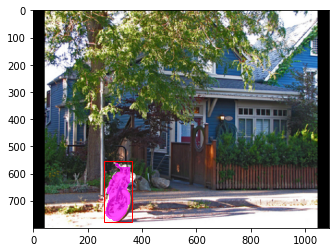

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[419.53201294 128.67314148 480.61880493 313.2911377 ]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

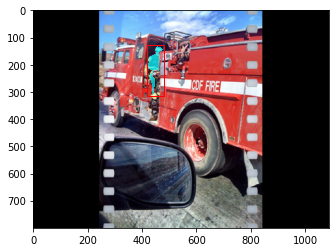

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([2, 800, 1088])
[[ 74.96697235 136.08613586 786.77313232 616.68615723]
 [ 87.98500824 283.03399658 659.81585693 644.0291748 ]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

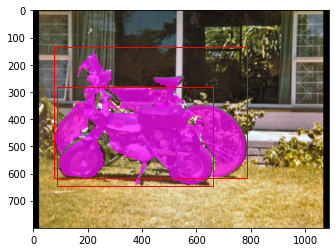

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[206.5776825  209.01094055 566.86901855 688.59301758]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

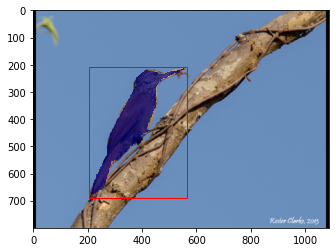

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])


KeyboardInterrupt: ignored

torch.Size([1, 800, 1088])
[[380.41183472   8.60598278 805.0748291  690.74328613]]


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

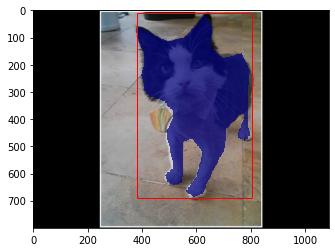

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[ 127.84358978  137.93887329 1060.92675781  609.52764893]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

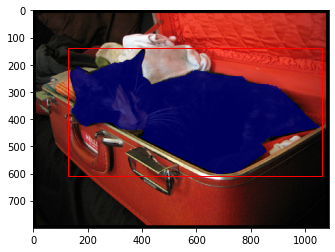

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([2, 800, 1088])
[[394.22280884 349.19845581 757.14581299 721.80114746]
 [461.64318848  96.4704361  764.25390625 552.95281982]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

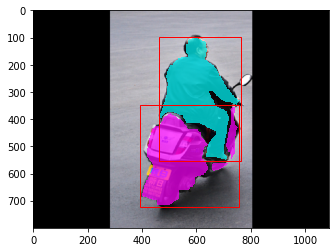

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[ 16.39662552  12.59906292 745.8237915  786.59875488]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

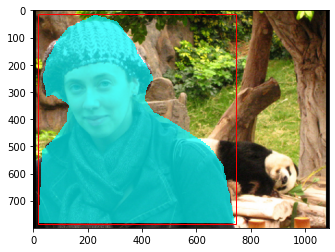

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([2, 800, 1088])
[[  12.59899998  346.28234863  635.6427002   701.60925293]
 [ 611.37451172   31.77300072 1046.85217285  347.76751709]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

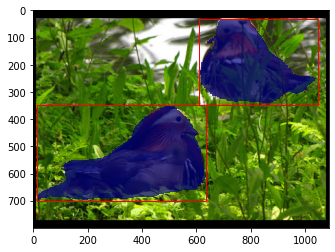

(3, 300, 400)
(3, 300, 400)
(3, 300, 400)
torch.Size([3, 300, 400])
torch.Size([3, 400, 300])
torch.Size([3, 400, 800])
torch.Size([3, 800, 400])
torch.Size([3, 800, 1066])
torch.Size([1, 800, 1088])
[[534.37268066 258.03881836 759.23205566 645.15545654]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

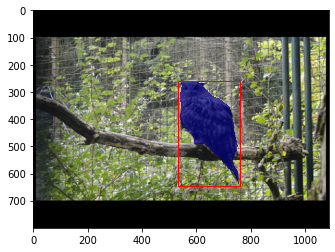

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from PIL import Image
mask_color_list = [ "Spectral", "spring", "cool","jet", "ocean"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for iter, data in enumerate(train_loader, 0):

    img, label, mask, bbox = [data[i] for i in range(len(data))]
 
    assert img.shape == (batch_size, 3, 800, 1088)
    assert len(mask) == batch_size


    plt.figure()
    for i in range(batch_size):

        fig,ax = plt.subplots(1)
        print(mask[i].shape)
        print(bbox[i])
        plt.imshow(img[i].numpy().transpose((1,2,0)).astype('long'))
        if (len(mask[i])>1):
          m1=mask[i][0]
          m2=mask[i][1]
          m1 = np.reshape(m1,(800,1088,1))
          maskedm1 = np.ma.masked_where(m1 == 0, m1)
          maskedm1=np.squeeze(maskedm1)
          plt.imshow(maskedm1, cmap=mask_color_list[label[i][0].item()], alpha=0.7)
          m2 = np.reshape(m2,(800,1088,1))
          maskedm2 = np.ma.masked_where(m2 == 0, m2)
          maskedm2=np.squeeze(maskedm2)
          plt.imshow(maskedm2, cmap=mask_color_list[label[i][1].item()], alpha=0.7)  
        else: 
          mask[i] = np.reshape(mask[i],(800,1088,len(mask[i])))
          masked = np.ma.masked_where(mask[i] == 0, mask[i])
          masked=np.squeeze(masked)
          plt.imshow(masked, cmap=mask_color_list[label[i].item()], alpha=0.7)
        for j in range(len(label[i])):
          rect1 = patches.Rectangle((bbox[i][j][0],bbox[i][j][1]),(bbox[i][j][2]-bbox[i][j][0]),(bbox[i][j][3]-bbox[i][j][1]),linewidth=1,edgecolor='r',facecolor='none')
          ax.add_patch(rect1)
        plt.show()

        plt.savefig("/content/"+str(iter)+".png")
        if i == 5:
          break
  

# **SOLO_HEAD**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import metrics
from scipy import ndimage

from functools import partial


In [ ]:
class SOLOHead(nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels=256,
                 seg_feat_channels=256,
                 stacked_convs=7,
                 strides=[8, 8, 16, 32, 32],
                 scale_ranges=((1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)),
                 epsilon=0.2,
                 num_grids=[40, 36, 24, 16, 12],
                 cate_down_pos=0,
                 with_deform=False,
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                alpha=0.25,
                                weight=1),
                 postprocess_cfg=dict(cate_thresh=0.2,
                                      ins_thresh=0.5,
                                      pre_NMS_num=50,
                                      keep_instance=5,
                                      IoU_thresh=0.5),\
                 device = torch.device("cuda" if torch.cuda.is_available else "cpu")):
        super(SOLOHead, self).__init__()
        self.num_classes = num_classes
        self.seg_num_grids = num_grids
        self.cate_out_channels = self.num_classes - 1
        self.in_channels = in_channels
        self.seg_feat_channels = seg_feat_channels
        self.stacked_convs = stacked_convs
        self.strides = strides
        self.epsilon = epsilon
        self.cate_down_pos = cate_down_pos
        self.scale_ranges = scale_ranges
        self.with_deform = with_deform
        self.device = device
        self.mask_loss_cfg = mask_loss_cfg
        self.cate_loss_cfg = cate_loss_cfg
        self.postprocess_cfg = postprocess_cfg

        self._init_layers()
        self._init_weights()


        assert len(self.ins_head) == self.stacked_convs
        assert len(self.cate_head) == self.stacked_convs
        assert len(self.ins_out_list) == len(self.strides)
        pass

    def _init_layers(self):
    
      num_groups = 32

      self.layers = []

    
      self.cate_head = nn.ModuleList()
      for i in range(7):
          self.layers.append(nn.Conv2d(256,256,kernel_size = 3,stride=1,padding=1,bias=False))
          self.cate_head.append(nn.Sequential(nn.Conv2d(256,256,kernel_size = 3,stride=1,padding=1,bias=False), nn.GroupNorm(num_groups,256),nn.ReLU()))
      
 
      self.layers.append(nn.Conv2d(256, self.cate_out_channels, kernel_size = 3,padding=1,bias = True))
      self.cate_out =  nn.Sequential(nn.Conv2d(256, self.cate_out_channels, kernel_size = 3,padding=1,bias = True), nn.Sigmoid())

     
      self.ins_head = nn.ModuleList()
      self.layers.append(nn.Conv2d(258,256,kernel_size=3 , stride=1, padding=1, bias = False))
      self.ins_head.append( nn.Sequential(nn.Conv2d(258,256,kernel_size=3 , stride=1, padding=1, bias = False),nn.GroupNorm(num_groups,256),nn.ReLU()))
      for i in range(6):
          self.layers.append(nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1,bias = False))
          self.ins_head.append(nn.Sequential(nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1,bias = False), nn.GroupNorm(num_groups,256),nn.ReLU()))
      

      self.ins_out_list = nn.ModuleList()
      for i in range(len(self.seg_num_grids)):
          self.layers.append(nn.Conv2d(256, (self.seg_num_grids[i])**2, kernel_size=1, bias = True))
          self.ins_out_list.append(nn.Sequential(nn.Conv2d(256, (self.seg_num_grids[i])**2, kernel_size=1, bias = True),nn.Sigmoid()))



 
    def _init_weights(self):
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)

  
    def forward(self,
              fpn_feat_list,
              eval=False):
      new_fpn_list = self.NewFPN(fpn_feat_list)  # stride[8,8,16,32,32]
      assert new_fpn_list[0].shape[1:] == (256,100,136)
      quart_shape = [new_fpn_list[0].shape[-2]*2, new_fpn_list[0].shape[-1]*2]  # stride: 4 

    
      cate_pred_list, ins_pred_list = self.MultiApply(
          self.forward_single_level, 
          new_fpn_list,
          list(range(len(new_fpn_list))), 
          eval=eval,
          upsample_shape = quart_shape
      )

      assert len(new_fpn_list) == len(self.seg_num_grids)

  
      assert ins_pred_list[1].shape[1] == self.seg_num_grids[1]**2
      assert cate_pred_list[1].shape[2] == self.seg_num_grids[1]
      return cate_pred_list, ins_pred_list

 
    def NewFPN(self, fpn_feat_list):
        new_fpn_list = fpn_feat_list
        new_fpn_list[0] = torch.nn.functional.interpolate(new_fpn_list[0], size=(100, 136), mode = 'bilinear', align_corners=False)
        new_fpn_list[-1] = torch.nn.functional.interpolate(new_fpn_list[-1], size=(25, 34), mode = 'bilinear', align_corners=False)
        return new_fpn_list


 
  
    def forward_single_level(self, fpn_feat, idx, eval=False, upsample_shape=None):

        cate_pred = fpn_feat.cuda()
        ins_pred = fpn_feat.cuda()
      
        cate_pred = torch.nn.functional.interpolate(cate_pred,size=self.seg_num_grids[idx], mode='bilinear')
        cate_pred = self.cate_head[0](cate_pred)
        cate_pred = self.cate_head[1](cate_pred)
        cate_pred = self.cate_head[2](cate_pred)
        cate_pred = self.cate_head[3](cate_pred)
        cate_pred = self.cate_head[4](cate_pred)
        cate_pred = self.cate_head[5](cate_pred)
        cate_pred = self.cate_head[6](cate_pred)
            
        cate_pred = self.cate_out(cate_pred)
       
        bz = fpn_feat.shape[0]
        H_FEAT = fpn_feat.shape[2]
        W_FEAT = fpn_feat.shape[3]
        yv, xv = torch.meshgrid([torch.linspace(-1,1,H_FEAT), torch.linspace(-1,1,W_FEAT)])
        yv = yv.to(self.device)
        xv = xv.to(self.device)
        yv = yv.view(1,1,H_FEAT,W_FEAT)
        yv = torch.cat([yv]*bz)
        xv = xv.view(1,1,H_FEAT,W_FEAT)
        xv = torch.cat([xv]*bz)

        ins_pred = torch.cat([ins_pred,xv,yv],1)
        
        ins_pred = self.ins_head[0](ins_pred)
        ins_pred = self.ins_head[1](ins_pred)
        ins_pred = self.ins_head[2](ins_pred)
        ins_pred = self.ins_head[3](ins_pred)
        ins_pred = self.ins_head[4](ins_pred)
        ins_pred = self.ins_head[5](ins_pred)
        ins_pred = self.ins_head[6](ins_pred)
        
        ins_pred = self.ins_out_list[idx](ins_pred)
 
        if eval == True:
        
            cate_pred = torch.nn.functional.interpolate(cate_pred,size=self.seg_num_grids[idx],mode='bilinear')
            cate_pred = self.points_nms(cate_pred).permute(0,2,3,1)
 
            ins_pred = torch.nn.functional.interpolate(ins_pred,size=upsample_shape, mode='bilinear')


      
        if eval == False:

            ins_pred = torch.nn.functional.interpolate(ins_pred,size=(2*H_FEAT,2*W_FEAT), mode='bilinear')

        else:
            pass
      
        return cate_pred, ins_pred            


   
    def points_nms(self, heat, kernel=2):
     
        hmax = nn.functional.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep

    This function compute loss for a batch of images
    input:
        cate_pred_list: list, len(fpn_level), each (bz,C-1,S,S)
        ins_pred_list: list, len(fpn_level), each (bz, S^2, 2H_feat, 2W_feat)
        ins_gts_list: list, len(bz), list, len(fpn), (S^2, 2H_f, 2W_f)
        ins_ind_gts_list: list, len(bz), list, len(fpn), (S^2,)
        cate_gts_list: list, len(bz), list, len(fpn), (S, S), {1,2,3}
    output:
        cate_loss, mask_loss, total_loss
    def loss(self,
             cate_pred_list,
             ins_pred_list,
             ins_gts_list,
             ins_ind_gts_list,
             cate_gts_list):
       
        ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img,...]for ins_labels_level_img,ins_ind_labels_level_img in zip(ins_labels_level,ins_ind_labels_level)],0)\
                  for ins_labels_level,ins_ind_labels_level in zip(zip(*ins_gts_list),zip(*ins_ind_gts_list))]
        ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img,...]\
                               for ins_preds_level_img,ins_ind_labels_level_img in\
                               zip(ins_preds_level,ins_ind_labels_level)],0)\
                    for ins_preds_level,ins_ind_labels_level in\
                    zip(ins_pred_list,zip(*ins_ind_gts_list))]
        cate_gts = [torch.cat([cate_gts_level_img.flatten()\
                               for cate_gts_level_img in cate_gts_level])\
                    for cate_gts_level in zip(*cate_gts_list)]
        cate_gts = torch.cat(cate_gts)
        cate_preds = [cate_pred_level.permute(0,2,3,1).reshape(-1,self.cate_out_channels)\
                      for cate_pred_level in cate_pred_list]
        cate_preds = torch.cat(cate_preds,0)

        
        cate_loss = self.FocalLoss(cate_preds,cate_gts)
        mask_loss = 0
 
        total_masks = 0.0000001
        for level in range(len(ins_preds)):
          level_mask_loss = 0
          for i in range(len(ins_preds[level])):
              level_mask_loss += 1-self.DiceLoss(ins_preds[level][i].cpu(),ins_gts[level][i])
          total_masks += ins_preds[level].size(0)
          mask_loss += level_mask_loss
        mask_loss /= total_masks

        total_loss = cate_loss + self.mask_loss_cfg['weight']*mask_loss
        return cate_loss,mask_loss,total_loss
        


   
    def DiceLoss(self, mask_pred, mask_gt):
      
          DL = 2*torch.sum(mask_pred*mask_gt)/(torch.sum(mask_pred*mask_pred)+torch.sum(mask_gt*mask_gt))
          return DL

  
    def MultiApply(self, func, *args, **kwargs):
        pfunc = partial(func, **kwargs) if kwargs else func
        map_results = map(pfunc, *args)

        return tuple(map(list, zip(*map_results)))

   
    def target(self,
               bbox_list,
               label_list,
               mask_list):
     
        featmap_sizes = [(100,136),(100,136),(50,68),(25,34),(25,34)]
        ins_gts_list,ins_ind_gts_list,cate_gts_list = self.MultiApply(self.target_single_img,bbox_list,label_list,mask_list,featmap_sizes=featmap_sizes)
        assert ins_gts_list[0][1].cpu().numpy().shape == (self.seg_num_grids[1]**2, 200, 272)
        assert ins_ind_gts_list[0][1].cpu().numpy().shape == (self.seg_num_grids[1]**2,)
        assert cate_gts_list[0][1].cpu().numpy().shape == (self.seg_num_grids[1], self.seg_num_grids[1])

        return ins_gts_list, ins_ind_gts_list, cate_gts_list
   
    def target_single_img(self,
                          gt_bboxes_raw,
                          gt_labels_raw,
                          gt_masks_raw,
                          featmap_sizes=None):
    
        ins_label_list = []
        ins_ind_label_list = []
        cate_label_list = []
        for i in range(len(self.seg_num_grids)):
           fpnlevel_h = featmap_sizes[i][0]
           fpnlevel_w = featmap_sizes[i][1]
           num_grids = self.seg_num_grids[i]
           cate_labels = torch.zeros((num_grids,num_grids),device=self.device)
           ins_labels = torch.zeros((num_grids**2,2*fpnlevel_h,2*fpnlevel_w),device=self.device)
           ins_ind_label = torch.zeros((num_grids**2,),dtype=torch.bool,device=self.device)
           min_scale = self.scale_ranges[i][0]
           max_scale = self.scale_ranges[i][1]
           for obj in range(len(gt_bboxes_raw)):
               x1,y1,x2,y2 = gt_bboxes_raw[obj]
               mask = gt_masks_raw[obj]
               label = gt_labels_raw[obj]
               ins_scale = ((x2-x1)*(y2-y1))**0.5
               if ins_scale>=min_scale and ins_scale<max_scale:
                   center_h,center_w = ndimage.measurements.center_of_mass(mask.long().numpy())
               
                   ori_h = mask.shape[0]
                   ori_w = mask.shape[1]
                   center_grid_i = int(center_h/ori_h*num_grids)
                   center_grid_j = int(center_w/ori_w*num_grids)
                   half_h,half_w = self.epsilon*(y2-y1)/2 , self.epsilon*(x2-x1)/2
                   top_ind = max(0,int((center_h-half_h)/ori_h*num_grids))
                   bottom_ind = min(num_grids-1,int((center_h+half_h)/ori_h*num_grids))
                   left_ind = max(0,int((center_w-half_w)/ori_w*num_grids))
                   right_ind = min(num_grids-1,int((center_w+half_w)/ori_w*num_grids))
 
              
                   top = max(top_ind,center_grid_i-1)
                   bottom = min(bottom_ind,center_grid_i+1)
                   left = max(left_ind,center_grid_j-1)
                   right = min(right_ind,center_grid_j+1)
                   mask_input = torch.unsqueeze(torch.unsqueeze(mask,0),0)
                   scaled_mask = nn.functional.interpolate(mask_input,size=(2*fpnlevel_h,2*fpnlevel_w),mode='bilinear')[0][0]
                  
                   for idx in range(top,bottom+1):
                       for idy in range(left,right+1):
                           k = idx*num_grids+idy
                           cate_labels[idx][idy] = label
                           ins_ind_label[k] = True
                           ins_labels[k] = scaled_mask
                   
                
           cate_label_list.append(cate_labels)
           ins_label_list.append(ins_labels)
           ins_ind_label_list.append(ins_ind_label)
 
        
        assert ins_label_list[1].shape == (1296,200,272)
        assert ins_ind_label_list[1].shape == (1296,)
        assert cate_label_list[1].shape == (36, 36)
        return ins_label_list, ins_ind_label_list, cate_label_list

   

    def PostProcess(self,
                    ins_pred_list,
                    cate_pred_list,
                    ori_size):
        a=[]
        NMS_sorted_scores_list=[]
        NMS_sorted_cate_label_list=[]
        NMS_sorted_ins_list=[]
        ## TODO: finish PostProcess
        for bz in range(len(cate_pred_list[0])):
          for i in range(len(cate_pred_list)):
            img_fpn=torch.zeros(cate_pred_list[i][bz].shape[0]**2,3)
            img_fpn=cate_pred_list[i][bz].reshape(cate_pred_list[i][bz].shape[0]**2,3)
            a.append(img_fpn)
          cate_pred_img=torch.cat((a[0],a[1],a[2],a[3],a[4]),0)
          ins_pred_img=torch.cat((ins_pred_list[0][bz],ins_pred_list[1][bz],ins_pred_list[2][bz],ins_pred_list[3][bz],ins_pred_list[4][bz]),0)
          print(cate_pred_img.shape)
          print(ins_pred_img.shape)
          NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins=self.MultiApply(self.PostProcessImg,ins_pred_img,cate_pred_img,ori_size)
        NMS_sorted_scores_list.append(NMS_sorted_scores)
        NMS_sorted_cate_label_list.append(NMS_sorted_cate_label)
        NMS_sorted_ins_list.append(NMS_sorted_ins)
        return NMS_sorted_scores_list,NMS_sorted_cate_label_list,NMS_sorted_ins_list

    
    def PostProcessImg(self,
                       ins_pred_img,
                       cate_pred_img,
                       ori_size):
        c_thresh=0.2
        i_thresh=0.5    
        sorted_scores=[]
        sorted_cate_label_list=[]
        sorted_ins=[]
        for i in range(len(cate_pred_img)):
          if (torch.max(cate_pred_img[i])>c_thresh):
        
            i_sum=0
            count=0
            for i in range(len(ins_pred_img[0])):
              for j in range(len(ins_pred_img[0][0])):
                if (ins_pred_img[i][j]>i_thresh):
                  i_sum+=ins_pred_img[i][j]
                  count+=1
            i_sum=i_sum/count
            sorted_scores.append(i_sum)
            sorted_cate_label_list.append(cate_pred_img[i])
            sorted_ins.append(ins_pred_img[i])

        sorted_scores, sorted_cate_label_list,sorted_ins = zip(*sorted(zip(sorted_scores, sorted_cate_label_list,sorted_ins),reverse=True))
        decay_scores=self.MultiApply(self.MatrixNMS,sorted_ins,sorted_scores, method='gauss', gauss_sigma=0.5)


        return NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins

 
    def MatrixNMS(self, sorted_ins, sorted_scores, method='gauss', gauss_sigma=0.5):
     
        ins=torch.FloatTensor(sorted_ins).cuda()
        for i in range(len(ins)):
          for j in range(len(ins[0])):
            for k in range(len(ins[0][0])):
              if (ins[i][j][k]>=0.5):
                ins[i][j][k]=1
              else:
                ins[i][j][k]=0   

        scores=torch.FloatTensor(sorted_scores).cuda()
        masks=ins.reshape(len(ins),len(ins[0])*len(ins[0][0]))
        intersection=torch.matmul(masks, masks.T)
        areas=masks.sum(dim=1).expand(len(ins),len(ins)).T
        union=areas+areas.T-intersection
        ious=(intersection/union).triu(diagonal=1)
        ious_cmax,_=ious.max(0)
        ious_cmax=ious_cmax.expand(len(ins),len(ins)).T
        ious=ious.cpu().numpy()
        ious_cmax=ious_cmax.cpu().numpy()
        decay=np.zeros((len(ins),len(ins)))
        for i in range(len(ins)):
          for j in range(len(ins)):
            if method=='gauss':
              decay[i][j]=math.exp(-(ious[i][j]**2-ious_cmax[i][j]**2)/gauss_sigma)
            else:
              decay[i][j]=(1-ious[i][j])/(1-ious_cmax[i][j])
        print(decay)
        decay=np.amin(decay, axis=0)
        scores=scores.cpu().numpy()
        scores=scores*decay
        
        return scores

   
    def PlotGT(self,
               ins_gts_list,
               ins_ind_gts_list,
               cate_gts_list,
               color_list,
               img):
      
        for bz in range(len(ins_gts_list)):
            ins_curr = ins_gts_list[bz]
            ins_ind_curr = ins_ind_gts_list[bz]
            cate_curr = cate_gts_list[bz]
            img_curr = img[bz]
            img_curr = img_curr.permute(1,2,0).data.long().numpy()
            for level in range(len(self.seg_num_grids)):
                plt.imshow(img_curr)
                for i in range(self.seg_num_grids[level]):
                    for j in range(self.seg_num_grids[level]):
                        k = i*self.seg_num_grids[level]+j
                        if ins_ind_curr[level][k]:
                            mask = ins_curr[level][k]
                            category = int(cate_curr[level][i][j].item())
                            color = color_list[category-1]
                            mask = torch.unsqueeze(torch.unsqueeze(mask,0),0)
                            mask = nn.functional.interpolate(mask,size=(800,1088),mode='bilinear')[0][0]
                            mask_new = np.ma.masked_where(mask.cpu().data.numpy()==0,mask.cpu().data.numpy())
                            plt.imshow(mask_new,cmap=color,alpha=0.5)
                plt.show()
      

      

    def PlotInfer(self,
                  NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  color_list,
                  img,
                  iter_ind):
      
      for i in range(len(NMS_sorted_scores_list)):
        for i in range(label.shape[0]):
          clas = label[i]
          mask2 = mask[i]
          print(mask[i].shape) 
        
          label = decay_labels[i]
          mask = mask[i]
          image=img[0]
          if (label == 1):
            image[mask == 1,2] = 700
          if (label == 3):
            image[mask == 1,0] = 700
          if (label == 2):
            image[mask == 1,1] = 700
          plt.imshow(image.data.long())
          plt.show()

#**BACKBONE**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def Resnet50Backbone(checkpoint_file=None, device="cpu", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)


        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

# **TRAINING**

In [ ]:
resnet50_fpn = Resnet50Backbone(device = device)
solo_head = SOLOHead(num_classes=4) 

In [ ]:
num_epochs=36
resume=False
resume_epochs=0
solo_head = solo_head.to(device)
resnet50_fpn = Resnet50Backbone(device=device)
optimizer = optim.SGD(solo_head.parameters(),lr=0.05)
epochsdone = 0
path = ''
if resume:
  path = '/content/gdrive/My Drive/CIS680_2019/HW3b_Mohitrajhu/SOLO9'+str(resume_epochs)
  checkpoint = torch.load(path)
  solo_head.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']

Mask_loss = []
Focal_loss = []
Total_loss = []
Iters = []
num_iters = 0
tot_cumulative_loss = 0
mask_cumulative_loss = 0
focal_cumulative_loss = 0
solo_head.train()
for epochs in range(num_epochs-epochsdone):
  start = time.time()

  for i, data in enumerate(train_loader,0):
    num_iters += 1
    optimizer.zero_grad()
    img, label_list, mask_list, bbox_list = [data[i] for i in range(len(data))]
    img = img.float()
    img=img.to(device)
    with torch.no_grad():
      backout = resnet50_fpn(img)
      fpn_feat_list = list(backout.values())
    del img
  
    cate_pred_list,ins_pred_list = solo_head.forward(fpn_feat_list,eval=False)
    del fpn_feat_list
    torch.cuda.empty_cache()
  

    ins_gts_list,ins_ind_gts_list,cate_gts_list = solo_head.target(bbox_list,label_list,mask_list)
    del bbox_list,label_list,mask_list
    focal_loss,mask_loss,total_loss = solo_head.loss(cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list)
    total_loss.backward()
    optimizer.step()
    if num_iters%100 != 0:
      tot_cumulative_loss += total_loss.cpu().item()
      mask_cumulative_loss+= mask_loss.cuda()
      focal_cumulative_loss += focal_loss.cpu().item()
    else:
      Total_loss.append(tot_cumulative_loss/100)
      Mask_loss.append(mask_cumulative_loss/100)
      Focal_loss.append(focal_cumulative_loss/100)
      tot_cumulative_loss = 0
      mask_cumulative_loss = 0
      focal_cumulative_loss = 0
      Iters.append(num_iters)
      print("Epoch: {} | Iteration: {} | Focal Loss: {} | Mask Loss: {} | Total Loss: {}".format(epochs+epochsdone+1,num_iters,focal_loss.cpu().item(),mask_loss,total_loss.cpu().item()))  
  
  print('time taken in epoch {}:{}'.format(epochs+epochsdone+1,time.time()-start))
 
  path = '/content/gdrive/My Drive/CIS680_2019/HW3b_Mohitrajhu/SOLO9'+str(epochs+epochsdone+1)
  torch.save({\
              'epoch': epochs+epochsdone+1,\
              'model_state_dict': solo_head.state_dict(),\
              'optimizer_state_dict':optimizer.state_dict()\
              },path)









    


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 1 | Iteration: 100 | Focal Loss: 0.0018493612296879292 | Mask Loss: 2.3206136226654053 | Total Loss: 2.322463035583496
Epoch: 1 | Iteration: 200 | Focal Loss: 0.0010348715586587787 | Mask Loss: 2.4678330421447754 | Total Loss: 2.4688680171966553
Epoch: 1 | Iteration: 300 | Focal Loss: 0.0011114277876913548 | Mask Loss: 1.399395227432251 | Total Loss: 1.400506615638733
Epoch: 1 | Iteration: 400 | Focal Loss: 0.0007182072731666267 | Mask Loss: 2.1765151023864746 | Total Loss: 2.1772332191467285
Epoch: 1 | Iteration: 500 | Focal Loss: 0.0007579416269436479 | Mask Loss: 2.016353130340576 | Total Loss: 2.01711106300354
Epoch: 1 | Iteration: 600 | Focal Loss: 0.0007393916021101177 | Mask Loss: 1.1581995487213135 | Total Loss: 1.1589388847351074
Epoch: 1 | Iteration: 700 | Focal Loss: 0.0011598463170230389 | Mask Loss: 1.393865942955017 | Total Loss: 1.3950257301330566
Epoch: 1 | Iteration: 800 | Focal Loss: 0.0006655397010035813 | Mask Loss: 0.9659774303436279 | Total Loss: 0.96664297

Text(0, 0.5, 'Mask Loss')

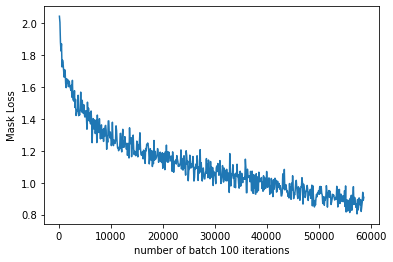

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Iters,Mask_loss)
plt.xlabel('number of batch 100 iterations')
plt.ylabel('Mask Loss')

Text(0, 0.5, 'Total Loss')

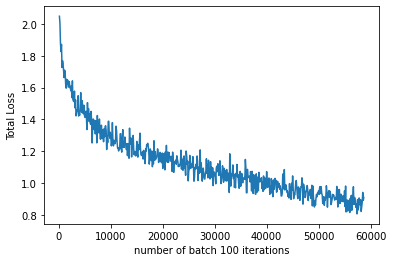

In [ ]:
plt.plot(Iters,Total_loss)
plt.xlabel('number of batch 100 iterations')
plt.ylabel('Total Loss')

Text(0, 0.5, 'Category Loss')

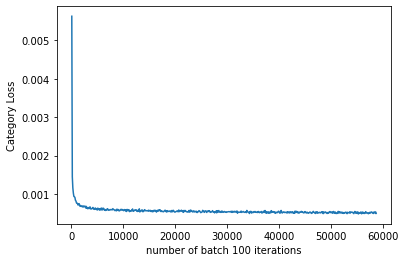

In [ ]:
plt.plot(Iters,Focal_loss)
plt.xlabel('number of batch 100 iterations')
plt.ylabel('Category Loss')